## Data Cleaning and Preparation

New York State Block Group Shapefile Source: 
https://catalog.data.gov/dataset/tiger-line-shapefile-2013-state-new-york-current-block-group-state-based

AirBnb Data Source: 
http://insideairbnb.com/get-the-data.html


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import shapely.geometry as geoms
from geopandas.tools import sjoin

Paths: 

In [217]:
listingspath = 'listings-2.csv'
#neighborhoodpath = 'neighbourhoods.geojson'
boroughspath = 'Borough Boundaries/geo_export_31e828ed-6fe9-44a8-b2de-15f7423e224d.shp'

Variables we want to keep:

In [218]:
vars = ['id', 'longitude', 'latitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 
        'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
        'minimum_nights', 'maximum_nights','number_of_reviews',
       'reviews_per_month', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
       'review_scores_location','review_scores_value']

In [219]:
df = pd.read_csv(listingspath)
df = df[vars].dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18035 entries, 1 to 44301
Data columns (total 23 columns):
id                             18035 non-null int64
longitude                      18035 non-null float64
latitude                       18035 non-null float64
property_type                  18035 non-null object
room_type                      18035 non-null object
accommodates                   18035 non-null int64
bathrooms                      18035 non-null float64
bedrooms                       18035 non-null float64
beds                           18035 non-null float64
price                          18035 non-null object
security_deposit               18035 non-null object
cleaning_fee                   18035 non-null object
minimum_nights                 18035 non-null int64
maximum_nights                 18035 non-null int64
number_of_reviews              18035 non-null int64
reviews_per_month              18035 non-null float64
review_scores_rating           18035 non-n

/Users/fatimakoli/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (43,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Convert latitude/longitude to proper geoms:

In [220]:
geos = gpd.GeoSeries(df[['longitude', 'latitude']]\
                     .apply(lambda x:geoms.Point((x.longitude, x.latitude)), 
                            axis=1), crs={'init':'epsg:4326'})
geos = geos.to_crs(epsg=2263)
df['geometry']= geos
df = gpd.GeoDataFrame.from_records(df)
df.crs = geos.crs

Let's visualize the different shapefiles we have: 

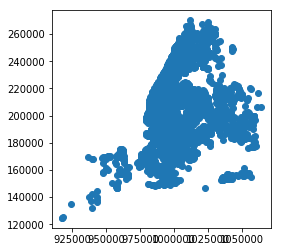

In [221]:
df.plot()

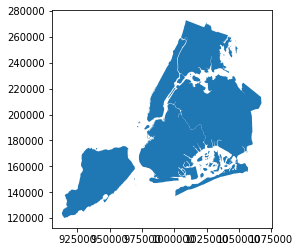

In [222]:
bor = gpd.read_file(boroughspath)
bor = bor.to_crs(epsg=2263)
bor.plot()

From InsideAirbnb:

230

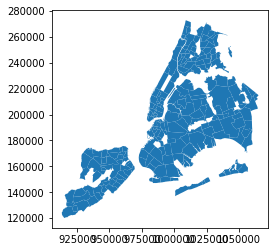

In [392]:
#neighborhoods = gpd.read_file(neighborhoodpath)
#neighborhoods = neighborhoods.to_crs(epsg=2263)
#neighborhoods.plot()

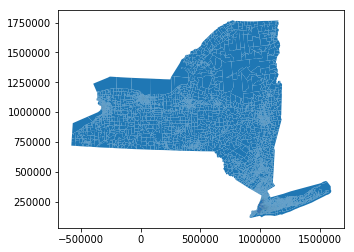

In [224]:
blockgroups = gpd.read_file('tl_2013_36_bg/tl_2013_36_bg.shp')
blockgroups = blockgroups.to_crs(epsg=2263)
blockgroups.plot()

CPU times: user 21.2 s, sys: 4.21 s, total: 25.4 s
Wall time: 26.3 s


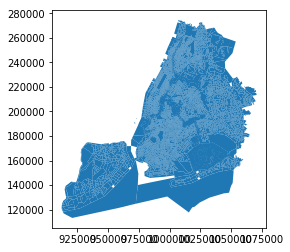

In [318]:
%%time

# will need the rtree extension for this
nycblock = sjoin(blockgroups, bor, how='inner')
nycblock.plot()

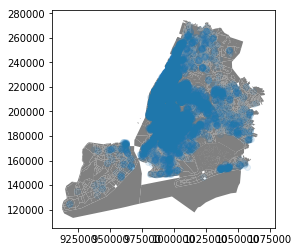

In [323]:
f, ax = plt.subplots(1, figsize=(4, 4))
nycblock.plot(ax=ax, color='grey', linewidth=0)
df.plot(ax=ax, alpha=0.1)

In [343]:
nycblock.shape
nycblock.info()
nycblock['GEOID'].nunique()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6497 entries, 0 to 12817
Data columns (total 18 columns):
STATEFP        6497 non-null object
COUNTYFP       6497 non-null object
TRACTCE        6497 non-null object
BLKGRPCE       6497 non-null object
GEOID          6497 non-null object
NAMELSAD       6497 non-null object
MTFCC          6497 non-null object
FUNCSTAT       6497 non-null object
ALAND          6497 non-null int64
AWATER         6497 non-null int64
INTPTLAT       6497 non-null object
INTPTLON       6497 non-null object
geometry       6497 non-null object
index_right    6497 non-null int64
shape_leng     6497 non-null float64
shape_area     6497 non-null float64
boro_name      6497 non-null object
boro_code      6497 non-null float64
dtypes: float64(3), int64(3), object(12)
memory usage: 964.4+ KB


6497

In [344]:
nycblock = nycblock.drop_duplicates('GEOID')
nycblock.shape

(6497, 18)

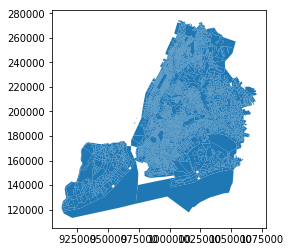

In [345]:
nycblock.plot()

## Joining AirBnb and Shapefile

In [346]:
df.crs

{'init': 'epsg:2263', 'no_defs': True}

In [347]:
nycblock.crs

{'init': 'epsg:2263', 'no_defs': True}

In [348]:
nycblock = nycblock.drop(['index_right'], axis=1)

In [353]:
%%time
abb_nyc = sjoin(df, nycblock, how='inner')
abb_nyc = abb_nyc.drop('index_right',axis=1)[vars +  ['GEOID', 'geometry']]
#.rename(columns={'id_right': 'block_id'})
#abb_man = abb_man.drop(['neighbourhood', 'neighbourhood_group'], axis=1)
# Keep complete rows
#abb_nyc = abb_nyc.drop('index_right', axis=1)\
#                    .dropna()\
#                    [vars + ['GEOID', 'geometry']]
#                   .rename(columns={'neighbourhood': 'neighbourhood_id'})

CPU times: user 1.41 s, sys: 20.2 ms, total: 1.43 s
Wall time: 1.43 s


In [354]:
abb_nyc.shape

(18034, 25)

## Aggregate by Neighborhood

In [355]:
g = abb_nyc.groupby('GEOID')
nyc_abb = g.mean()
nyc_abb['property_count'] = g.size()

In [356]:
nyc_abb.shape

(3201, 19)

## Join with Polygons

In [361]:
nyc_abb['geometry'] = nycblock.set_index('GEOID').reindex(nyc_abb.index)['geometry']
nyc_abb
#nyc_abb.plot(column='property_count', linewidth=0)
nyc_abb = gpd.GeoDataFrame(nyc_abb, crs=nycblock.crs)

## Visualize

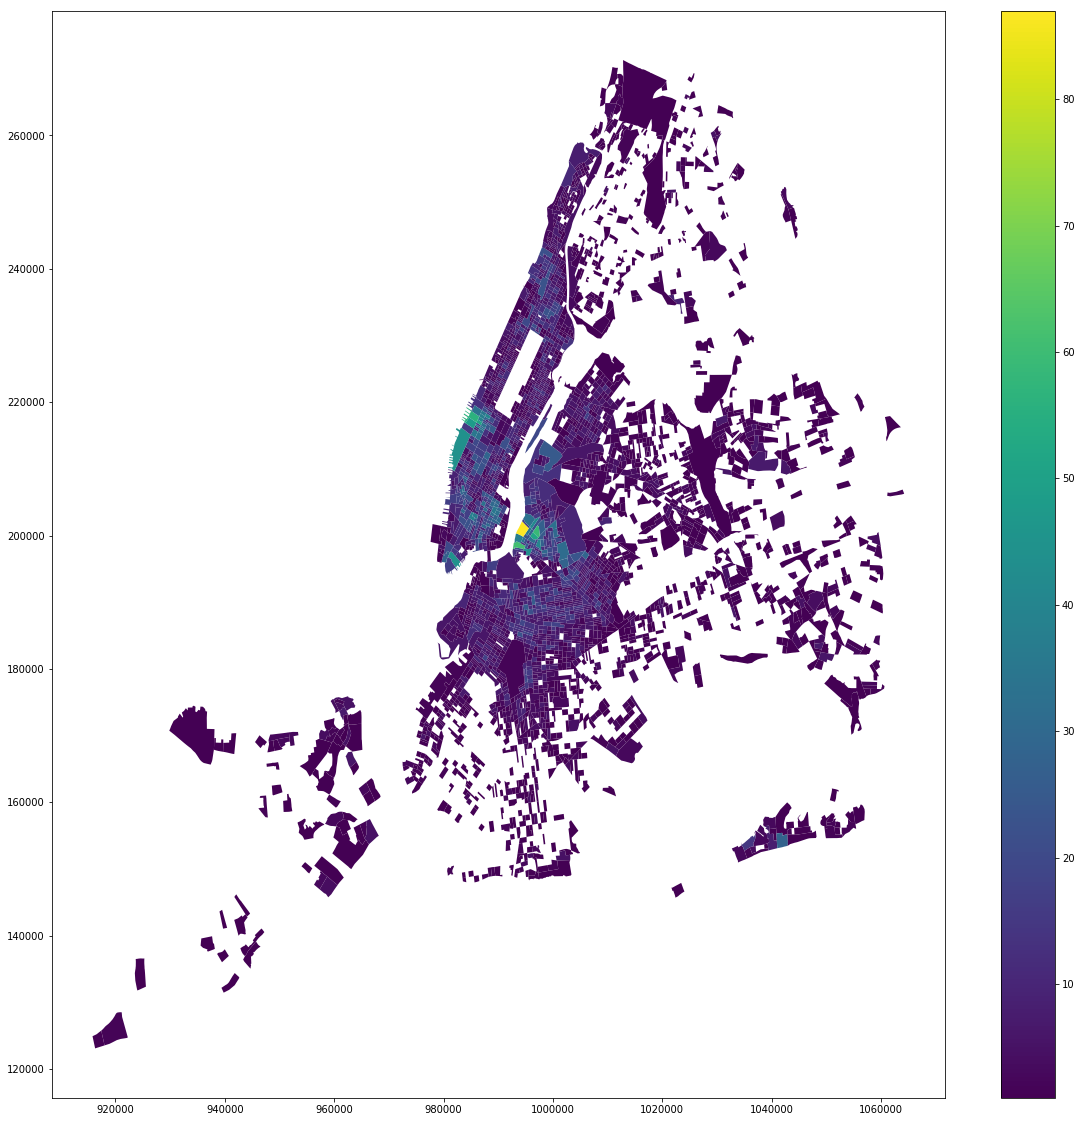

In [384]:
f, ax = plt.subplots(1, figsize=(20,20))
nyc_abb.plot(ax=ax, column='property_count',linewidth=0, legend=True)

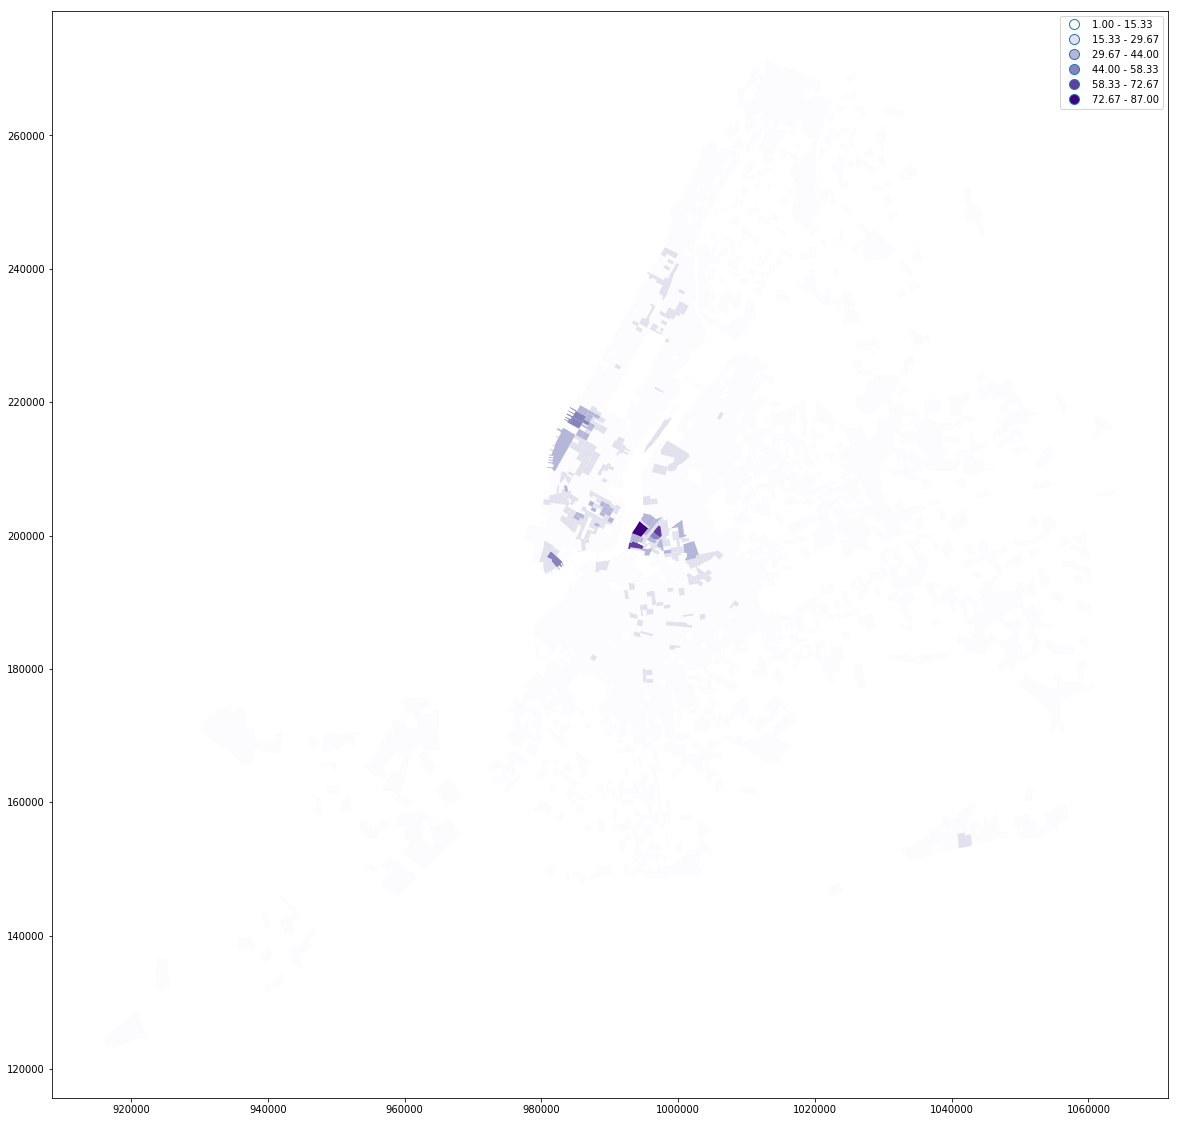

In [385]:
f, ax = plt.subplots(1, figsize=(20,20))
nyc_abb.plot(ax=ax, column='property_count',cmap = "Purples", linewidth=0, legend=True, scheme='equal_interval', k=6)

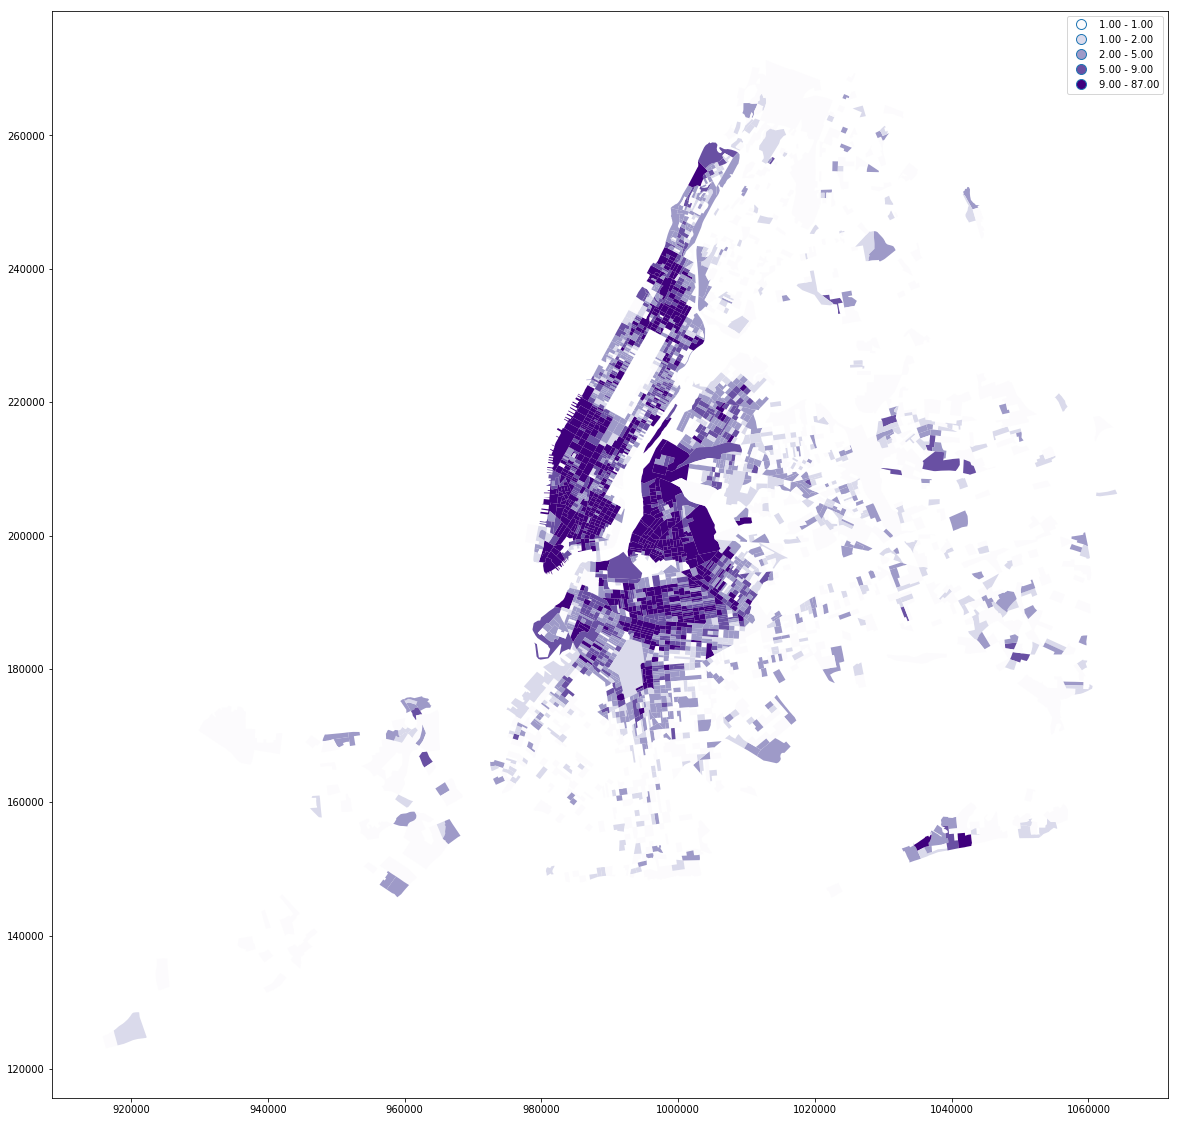

In [386]:
f, ax = plt.subplots(1, figsize=(20,20))
nyc_abb.plot(ax=ax, column='property_count',cmap='Purples', linewidth=0, scheme='quantiles', legend=True)

In [387]:
nyc_abb.to_file('nyc_abb.json', driver='GeoJSON')